In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)
print(device)

cuda


In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Oct 14 09:40:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
drive.mount('/content/drive')
dataset_zip = np.load("/content/drive/My Drive/animal10.npz")

Mounted at /content/drive


In [4]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.data = torch.from_numpy(np.rollaxis(dataset_zip["data"], 3, 1))
        self.target = torch.from_numpy(dataset_zip["target"]).long()
        self.tag = dataset_zip["translate"]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

    def translate(self, int_type_code):
        return [self.tag[i] for i in int_type_code]

In [5]:
dataset = DataSet()

In [6]:
test = torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(dataset.translate(test))

['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


In [10]:
class VGG11_CAM(nn.Module):

    def __init__(self):
        super(VGG11_CAM, self).__init__()
        pretrained_vgg11 = models.vgg11(pretrained=True)
        self.base = (pretrained_vgg11.features[0: -1]).to(device)
        self.avgpool = nn.AdaptiveAvgPool2d(1).to(device)
        self.importance_weights = nn.Linear(512, 10).to(device)

    def forward(self, x):
        A = self.base(x)
        logits = self.importance_weights(self.avgpool(A).view(x.size(0), -1))
        return logits

    def cam(self, x, classes):
        A = self.base(x)
        W = self.importance_weights.weight[classes].reshape(x.size(0), -1, 1, 1)
        CAM = (A * W).sum(dim=1)
        return F.relu(CAM).to(device)

In [11]:
mb_size = 64
vgg11_cam = VGG11_CAM()
solver = optim.Adam(vgg11_cam.parameters(), lr=1e-4)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=mb_size, shuffle=True, drop_last=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [12]:
num_epochs = 10
LOSS = []
for epoch in range(num_epochs):
    loss_avg = 0.0
    acc_avg = 0.0
    for _, (X, Y) in enumerate(loader):

        
        X = (X.float().to(device) - 127.5) / 127.5
        Y = Y.to(device)
        solver.zero_grad()
        logits_predicted = vgg11_cam(X)
        loss = F.cross_entropy(logits_predicted, Y, reduction='mean')
        acc_avg += (torch.argmax(logits_predicted, dim=-1) == Y).detach().cpu().numpy().mean()
        loss.backward()
        solver.step()
        loss_avg += loss.item()
    loss_avg /= len(loader)
    acc_avg /= len(loader)

    print('loss:', loss_avg, 'acc:', acc_avg)


loss: 0.49794930959243355 acc: 0.8425275061124694
loss: 0.21259759737219672 acc: 0.9347875916870416
loss: 0.1459006907003943 acc: 0.9557227995110025
loss: 0.09777522737884434 acc: 0.9713095965770171
loss: 0.07513295950978302 acc: 0.9775748777506112
loss: 0.053686786637115486 acc: 0.983916564792176
loss: 0.039877079260162096 acc: 0.9886537286063569
loss: 0.037884701340809956 acc: 0.9887301344743277
loss: 0.03288838222069543 acc: 0.9897998166259169
loss: 0.02748325209430485 acc: 0.9923976161369193


In [18]:
num_epochs = 20
LOSS = []
for epoch in range(num_epochs):
    loss_avg = 0.0
    acc_avg = 0.0
    for _, (X, Y) in enumerate(loader):

        
        X = (X.float().to(device) - 127.5) / 127.5
        Y = Y.to(device)
        solver.zero_grad()
        logits_predicted = vgg11_cam(X)
        loss = F.cross_entropy(logits_predicted, Y, reduction='mean')
        acc_avg += (torch.argmax(logits_predicted, dim=-1) == Y).detach().cpu().numpy().mean()
        loss.backward()
        solver.step()
        loss_avg += loss.item()
    loss_avg /= len(loader)
    acc_avg /= len(loader)

    print('loss:', loss_avg, 'acc:', acc_avg)


loss: 0.021714400321024317 acc: 0.9935055012224939
loss: 0.01695739994796726 acc: 0.9953010391198044
loss: 0.02794438936493717 acc: 0.9919773838630807
loss: 0.014085416261660058 acc: 0.996294315403423
loss: 0.007660478976937859 acc: 0.9976696210268948
loss: 0.019404806076218247 acc: 0.9938111246943765
loss: 0.0235949660588624 acc: 0.9931616748166259
loss: 0.01326619526362643 acc: 0.996638141809291
loss: 0.023050628208927015 acc: 0.9930088630806846
loss: 0.014747215322353895 acc: 0.9960268948655256
loss: 0.009402202744654248 acc: 0.9975168092909535
loss: 0.008440335466289882 acc: 0.9972111858190709
loss: 0.016236820742433825 acc: 0.9953392420537898
loss: 0.0017505594177462777 acc: 0.999770782396088
loss: 0.016627343634389637 acc: 0.9947279951100244
loss: 0.018304008716299093 acc: 0.9946515892420538
loss: 0.007604448430082498 acc: 0.9980134474327629
loss: 0.005835754852614739 acc: 0.9982044621026895
loss: 0.009055739169636808 acc: 0.9975932151589242
loss: 0.00040211228342015897 acc: 0.99

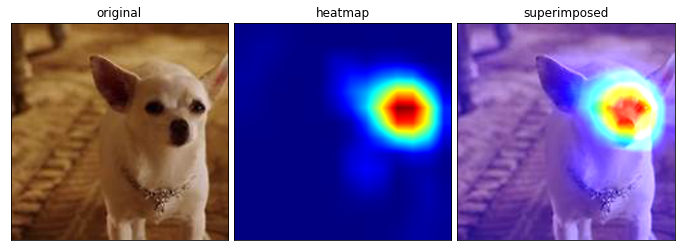

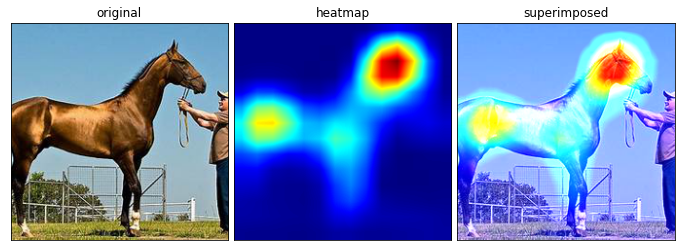

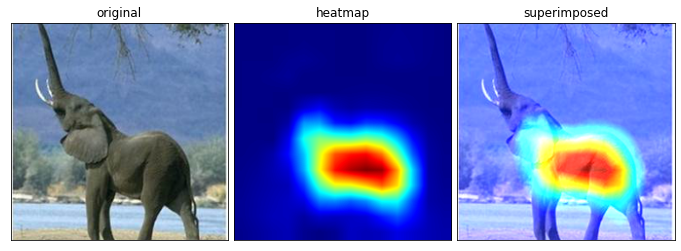

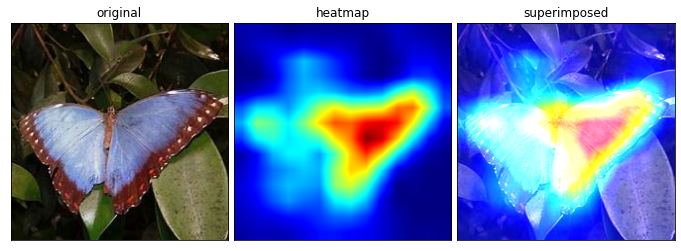

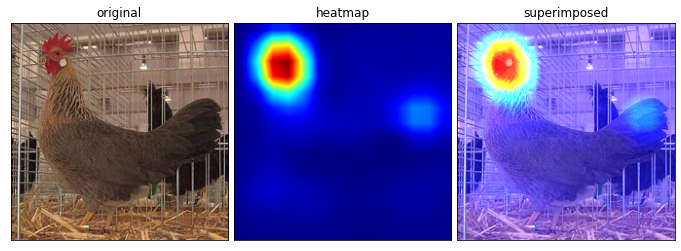

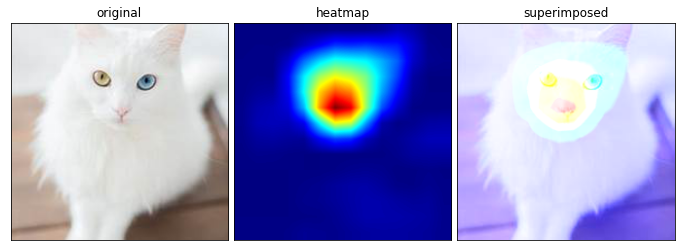

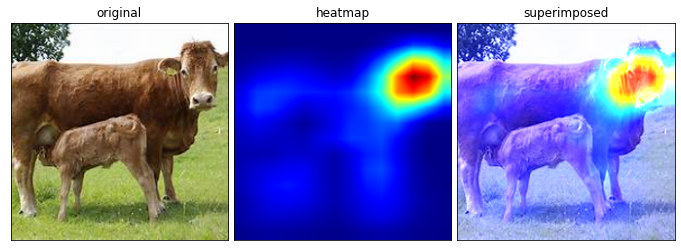

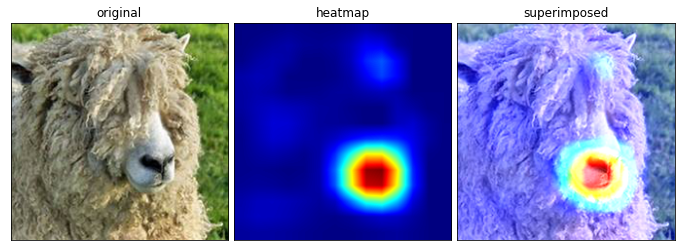

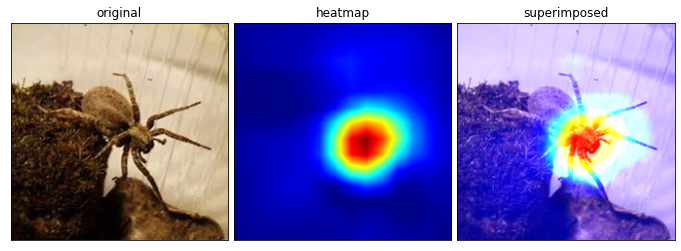

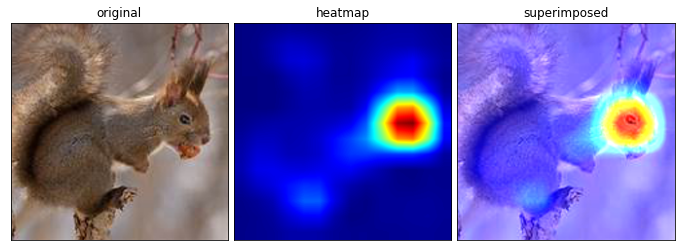

In [141]:
from PIL import Image
import cv2

def demo(idx):
    x = ((dataset.data[idx].float().to(device) - 127.5)/127.5).reshape(1, 3, 224, 224)

    cam = vgg11_cam.cam(x, dataset.target[idx]).reshape(14, 14).cpu().detach().numpy()
    cam = -cam
    cam = (cam - cam.min())/(cam.max() - cam.min())

    heatmap = cv2.resize(cam, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.rollaxis(dataset.data[idx].numpy(), 0, 3), 1.0, heatmap, 1.0, 0)
    fig = plt.figure(figsize=(12, 4))
    _fig = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    _fig.set_title('original')
    _fig.imshow(np.rollaxis(dataset.data[idx].numpy(), 0, 3))
    _fig = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    _fig.set_title('heatmap')
    _fig.imshow(heatmap)
    _fig = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    _fig.set_title('superimposed')

    _fig.imshow(superimposed_img)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

demo(3000)
demo(5000)
demo(8801)

demo(11000)
demo(14000)
demo(15000)

demo(17000)
demo(19010)

demo(23001)
demo(25000)
